# Project Overview

# Actually, I used an SVD model, not a hybrid model! Need to update the above!

# Datasets

This project utilizes the MovieLens dataset, a widely used dataset in the field of recommender systems, containing movie ratings and metadata.  The data was obtained at https://www.kaggle.com/datasets/parasharmanas/movie-recommendation-system/data.  There are two data files. The first contains the unique movie Id, movie title and a list of genres the movie falls into.  The second consists of user ratings with the user ID, movie ID, rating and timestap of when the review was made.

# PRIOR NOTES - MOVE

The plot above shows the trend of average movie ratings on a monthly basis. Observing the fluctuations in average ratings over time can provide insights into various factors, such as:
- User Rating Behavior: Changes in average ratings might indicate shifts in user rating behavior or the platform's user base.
- Content Quality: Variations might also reflect the release of particularly popular (or unpopular) movies during certain periods.


**Seasonal Trends in Movie Ratings**
- Average Ratings by Month: The bar chart provides a clear visualization of how average ratings vary by month. Peaks and troughs can suggest periods of high and low engagement or satisfaction, which can be tied to holiday seasons or specific movie releases.
- Genre Popularity by Month: The heatmap shows how different genres perform across months, revealing any seasonal preferences for genres. For example, holiday-themed or blockbuster genres might show distinct patterns during certain months like December or summer months.


Typical Accuracy Levels:

- General Accuracy: It's challenging to state a specific "average accuracy" because it depends highly on the context and the specific system configuration. However, good movie recommendation systems generally achieve:
    - RMSE: Values around 0.8 to 1.2 for rating predictions, with lower values indicating better accuracy.
    - Precision/Recall: Precision and recall can vary, but good systems might achieve over 20-30% precision in top-N recommendations in practical settings.
    - High-Performance Systems: In competitions like the Netflix Prize, the winning entries achieved RMSEs around 0.85, considered very high accuracy in a real-world system.

# REVISED CODE

In [48]:
# conda install joblib

In [49]:
## Optimized Code

## Import Libraries

In [9]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import precision_score, recall_score, f1_score
from collections import defaultdict
from joblib import Parallel, delayed
import logging
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# Use ggplto style for graphs
plt.style.use('ggplot')
sns.set_palette('colorblind')

# Set a random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Setup logging
logging.basicConfig(level=logging.INFO)


## Load and Merge Data

In [18]:
# Load and merge movies and ratings data with essential columns and a subset of ratings
def load_and_merge_data(movies_file, ratings_file):
    try:
        movies_df = pd.read_csv(movies_file, usecols=['movieId', 'title', 'genres'])
        ratings_df = pd.read_csv(ratings_file, usecols=['userId', 'movieId', 'rating'])

        # Remove duplicates
        movies_df.drop_duplicates(subset=['movieId'], inplace=True)
        ratings_df.drop_duplicates(subset=['userId', 'movieId'], inplace=True)

        # Handle missing values
        movies_df.fillna({'genres': '(no genres listed)'}, inplace=True)
        ratings_df.dropna(subset=['userId', 'movieId', 'rating'], inplace=True)

        merged_df = pd.merge(ratings_df, movies_df, on='movieId')
        logging.info("Data successfully merged and cleaned.")
        return merged_df
    except FileNotFoundError as e:
        logging.error(f"Error: {e}. File not found. Check the file paths.")
        return None
    except Exception as e:
        logging.error(f"An unexpected error occurred: {e}")
        return None


In [ ]:
CODE TO RUN

# Initial EDA

In [20]:
merged_df.head()

NameError: name 'merged_df' is not defined

In [11]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [12]:
movies_df.describe(include='all')

,movieId,title,genres
count,9742.000000,9742,9742
unique,NaN,9737,951
top,NaN,Emma (1996),Drama
freq,NaN,2,1053
mean,42200.353623,NaN,NaN
std,52160.494854,NaN,NaN
min,1.000000,NaN,NaN
25%,3248.250000,NaN,NaN
50%,7300.000000,NaN,NaN
75%,76232.000000,NaN,NaN


Movies Dataframe Summary:
- There are 9,742 unique movies.
- The genres column has 951 unique genre combinations, with 'Drama' being the most frequent.  The number of genres does not appear resaonable, so will conduct further analysis on.
- The movieId ranges from 1 to 193,609, indicating a broad and possibly sparse numbering system, as there are only 9,737 unique movie titles.

In [14]:
movies_df.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

There are no missing values in the movies dataset.

In [16]:
movies_df.duplicated().sum()

0

There are no duplicate rows in the movies dataset.

In [18]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [19]:
ratings_df.describe(include='all')

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


Ratings Dataframe Summary:
- Contains 100,836 ratings.
- userId ranges from 1 to 610, indicating 610 unique users.
- Ratings range from 0.5 to 5.0, in increments of 0.5.
- The average rating is approximately 3.50.
- timestamp is an integer representing the time the user rating was made.

I will now merge the two datasets which will allow us to see which user rated which movie, along with the movie's title and genres.

In [22]:
# Merge the two df's on movieId
df = movies_df.merge(ratings_df, on='movieId')

df.shape

(100836, 6)

In [23]:
df.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


In [24]:
df.isna().sum()

movieId      0
title        0
genres       0
userId       0
rating       0
timestamp    0
dtype: int64

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   movieId    100836 non-null  int64  
 1   title      100836 non-null  object 
 2   genres     100836 non-null  object 
 3   userId     100836 non-null  int64  
 4   rating     100836 non-null  float64
 5   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 4.6+ MB


In [26]:
df.describe(include='all')

,movieId,title,genres,userId,rating,timestamp
count,100836.000000,100836,100836,100836.000000,100836.000000,1.008360e+05
unique,NaN,9719,951,NaN,NaN,NaN
top,NaN,Forrest Gump (1994),Comedy,NaN,NaN,NaN
freq,NaN,329,7196,NaN,NaN,NaN
mean,19435.295718,NaN,NaN,326.127564,3.501557,1.205946e+09
std,35530.987199,NaN,NaN,182.618491,1.042529,2.162610e+08
min,1.000000,NaN,NaN,1.000000,0.500000,8.281246e+08
25%,1199.000000,NaN,NaN,177.000000,3.000000,1.019124e+09
50%,2991.000000,NaN,NaN,325.000000,3.500000,1.186087e+09
75%,8122.000000,NaN,NaN,477.000000,4.000000,1.435994e+09


Combined Dataset Statistics:
- The dataset contains 100,836 ratings for 9,719 unique movies.
- The genres column has 951 unique genre combinations, with 'Comedy' being the most frequent.
- Ratings range from 0.5 to 5.0, with an average of approximately 3.50.

In [28]:
df.isna().sum()

movieId      0
title        0
genres       0
userId       0
rating       0
timestamp    0
dtype: int64

There are no missing values in the combined dataset

In [30]:
df.duplicated().sum()

0

## Univariate Analysis

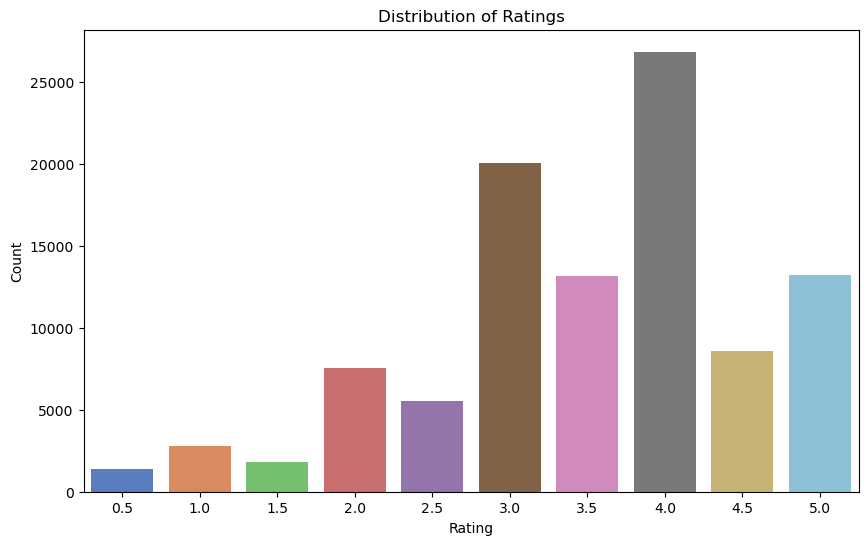

In [32]:
# Plot ratings distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', hue='rating', data=df, legend=False, palette='muted'
             )
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


The distribution of ratings shows that:
- Ratings are discrete, in increments of 0.5.
- The most common ratings are around 3.0 to 4.0, indicating a tendency towards higher ratings.
- The extreme ratings (0.5 and 5.0) are less common, suggesting that users are generally moderate in their assessments.

C:\Users\trobb\AppData\Local\Temp\ipykernel_6648\3179706429.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(genre_counts, kind='bar', palette='muted', height=5, aspect=2)


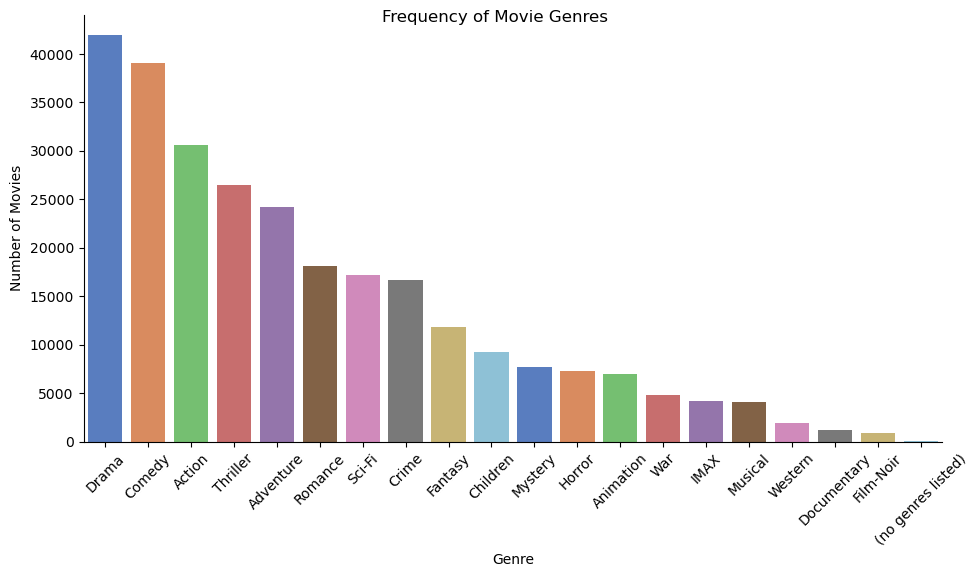

In [34]:
# split genres by | and add as a list
df['genres'] = df['genres'].apply(lambda x:x.split('|'))
                                  
df.head()

# Break out genres included in list and determine count of each
import matplotlib.pyplot as plt

# Explode the genres column to have separate row for each genre
exploded_genres = df.explode('genres')

# Count the occurrences of each genre
genre_counts = exploded_genres['genres'].value_counts()
genre_counts

# Plot the genre frequencies

g = sns.catplot(genre_counts, kind='bar', palette='muted', height=5, aspect=2)
g.fig.suptitle('Frequency of Movie Genres')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.show()

## Bivariate Analysis

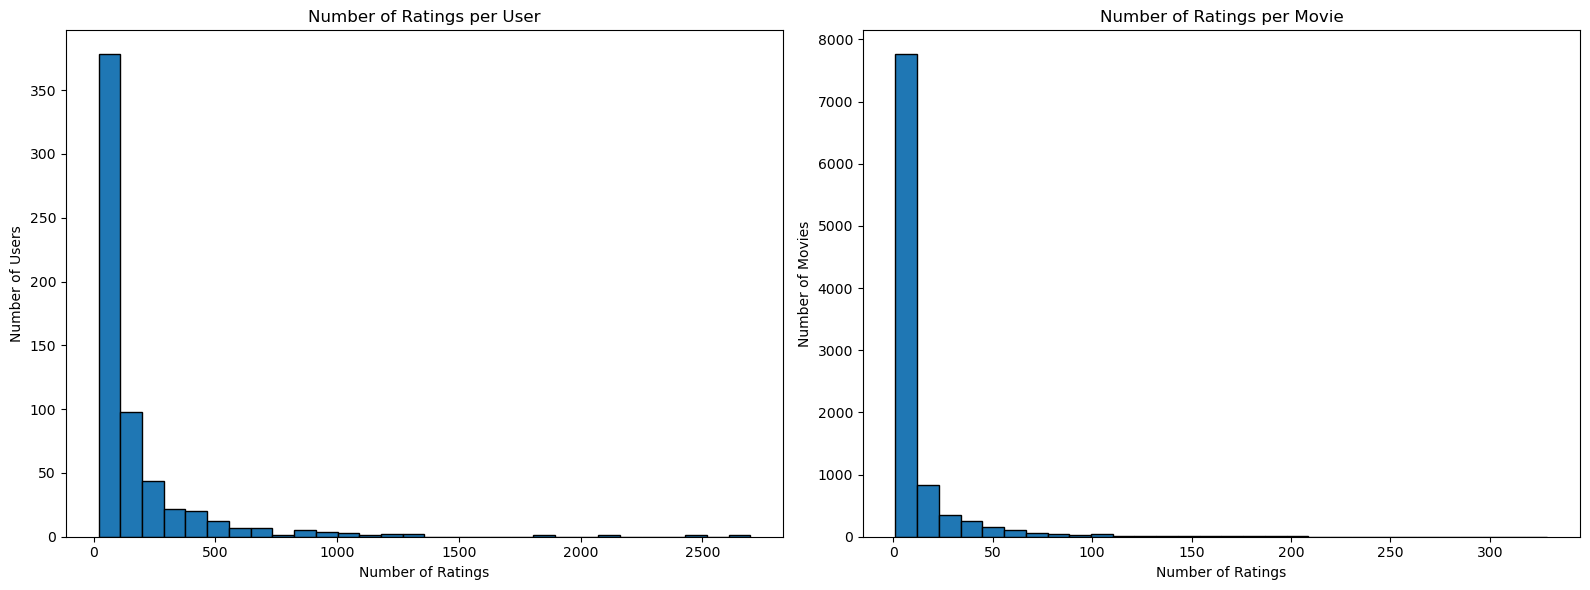

In [36]:
import matplotlib.pyplot as plt

# Assuming 'ratings_df' is your DataFrame
user_rating_counts = ratings_df['userId'].value_counts()
movie_rating_counts = ratings_df['movieId'].value_counts()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot for number of ratings per user
axes[0].hist(user_rating_counts, bins=30, edgecolor='black')
axes[0].set_title('Number of Ratings per User')
axes[0].set_xlabel('Number of Ratings')
axes[0].set_ylabel('Number of Users')

# Plot for number of ratings per movie
axes[1].hist(movie_rating_counts, bins=30, edgecolor='black')
axes[1].set_title('Number of Ratings per Movie')
axes[1].set_xlabel('Number of Ratings')
axes[1].set_ylabel('Number of Movies')

plt.tight_layout()
plt.show()



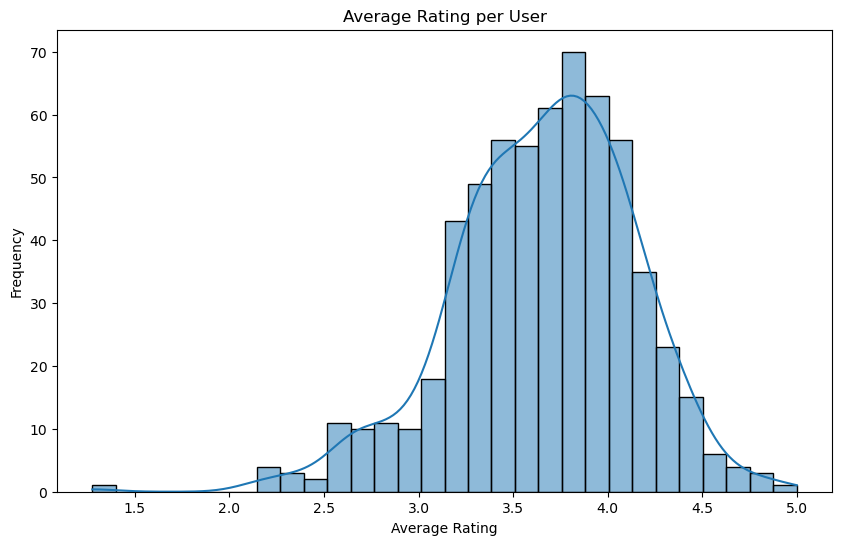

In [37]:
# Average Rating per User

import matplotlib.pyplot as plt
import seaborn as sns

# Calculate average rating per user
user_avg_ratings = ratings_df.groupby('userId')['rating'].mean()

plt.figure(figsize=(10, 6))
sns.histplot(user_avg_ratings, bins=30, kde=True)
plt.title('Average Rating per User')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()


# Distribution of Ratings across genres


## Need to add

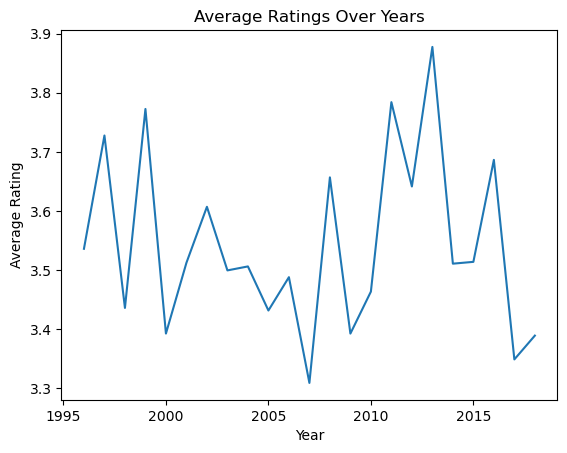

In [39]:
# Ratings over Time
ratings_df['datetime'] = pd.to_datetime(ratings_df['timestamp'], unit='s')
ratings_df['year'] = ratings_df['datetime'].dt.year
ratings_df.groupby('year')['rating'].mean().plot(kind='line')
plt.title('Average Ratings Over Years')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.show()


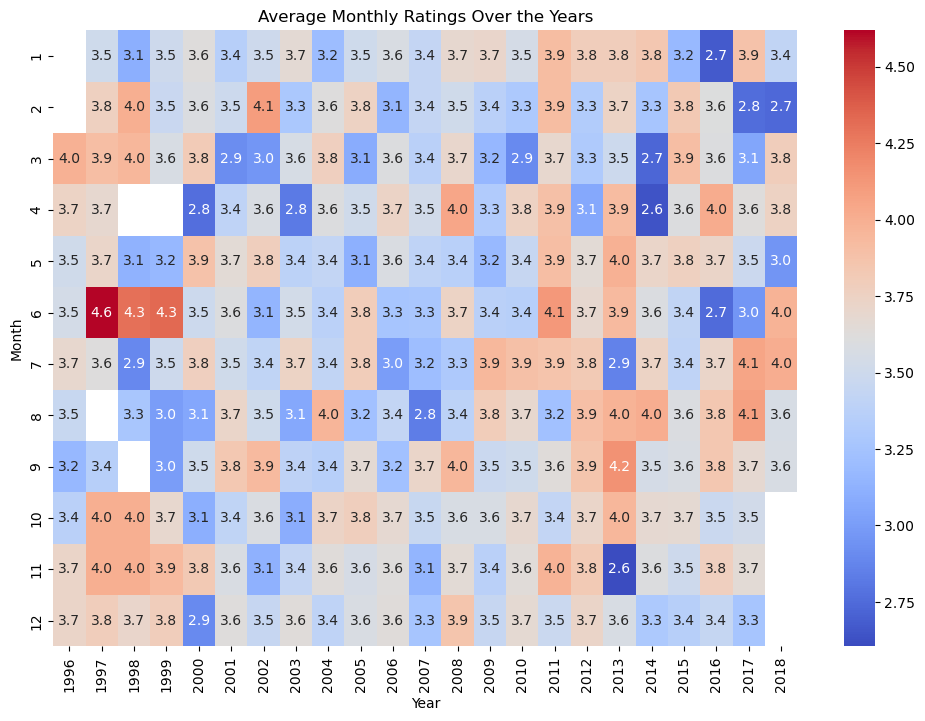

In [40]:
# Heatmap of Ratings Over Time

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'timestamp' is a UNIX timestamp in 'ratings_df'
ratings_df['date'] = pd.to_datetime(ratings_df['timestamp'], unit='s')
ratings_df['year'] = ratings_df['date'].dt.year
ratings_df['month'] = ratings_df['date'].dt.month

# Pivot table to prepare data for heatmap
rating_pivot = ratings_df.pivot_table(values='rating', index='month', columns='year', aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(rating_pivot, annot=True, fmt=".1f", cmap='coolwarm')
plt.title('Average Monthly Ratings Over the Years')
plt.xlabel('Year')
plt.ylabel('Month')
plt.show()



In [41]:
df.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1,4.0,964982703
1,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",5,4.0,847434962
2,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",7,4.5,1106635946
3,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",15,2.5,1510577970
4,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",17,4.5,1305696483


## Preprocess Data

In [56]:
# Preprocess data by adding one-hot encoding for genres
def preprocess_data(df):
    if 'genres' in df.columns:
        df['genres'] = df['genres'].replace('', '(no genres listed)')
        genres_dummies = df['genres'].str.get_dummies(sep='|')
        df = pd.concat([df, genres_dummies], axis=1)
        logging.info("Genre-based features added.")
    else:
        logging.info("Genres column not available for processing.")
    return df

# Add user-genre interaction features to the dataset
def add_user_genre_features(df):
    if 'userId' in df.columns:
        # Select only genre columns for aggregation
        genre_columns = [col for col in df.columns if col not in ('user_mean_', 'title', 'movieId', 'userId', 'rating') and df[col].dtype in [np.float64, np.int64]]

        # Compute mean genre features per user
        user_genre_means = df.groupby(['userId'])[genre_columns].mean()
        user_genre_means.columns = [f'user_mean_{col}' for col in user_genre_means.columns]

        # Merge the new features back into the main DataFrame
        df = pd.merge(df, user_genre_means, on='userId', how='left')
        logging.info("User-genre interaction features added.")
    else:
        logging.info("UserId column not available for interaction features.")
    return df

## Additional EDA

In [58]:
from joblib import Parallel, delayed
from sklearn.neighbors import NearestNeighbors
import logging

# Helper function for hybrid recommendations per user
def hybrid_user_recommendation_worker(user_id, df, svd_model, movie_indices, distances, indices, weight_svd, weight_content, n):
    user_recommendations = []

    try:
        for idx in movie_indices:
            sim_scores = list(enumerate(distances[idx]))
            sorted_indices = np.argsort([x[1] for x in sim_scores])[::-1][1:11]

            movie_indices_list = [indices[idx][i] for i in sorted_indices if indices[idx][i] in df.index]

            sim_movies = df['movieId'].iloc[movie_indices_list]
            svd_recs = [svd_model.predict(user_id, iid) for iid in sim_movies]

            recommendations = [
                (
                    iid,
                    weight_svd * est.est + weight_content * distances[idx][movie_indices_list.index(iid)]
                )
                for iid, est in zip(sim_movies, svd_recs)
                if iid in movie_indices_list
            ]

            recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)

            user_recommendations.extend(recommendations[:n])

        user_recommendations = sorted(user_recommendations, key=lambda x: x[1], reverse=True)[:n]

        return [(user_id, rec[0], rec[1]) for rec in user_recommendations]

    except ValueError as e:
        logging.error(f"Error in hybrid_user_recommendation_worker: {e}")
        return []

# Function to calculate sparse cosine similarity
def calculate_sparse_cosine_similarity(tfidf_matrix, n_neighbors=10):
    logging.info("Calculating sparse cosine similarity...")
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine', algorithm='brute').fit(tfidf_matrix)
    distances, indices = nbrs.kneighbors(tfidf_matrix)
    logging.info("Sparse cosine similarity calculated.")
    return distances, indices

# Hybrid recommendation function combining SVD and content-based filtering
def hybrid_recommendation_to_screen(df, svd_model, test_users, weight_svd=0.7, weight_content=0.3, n=5, batch_size=2000):
    movie_indices = pd.Series(df.index, index=df['title']).drop_duplicates()

    tfidf = TfidfVectorizer(max_features=1000, stop_words='english')  # Increase vocabulary size to 1000
    tfidf_matrix = tfidf.fit_transform(df['genres'].fillna(''))
    distances, indices = calculate_sparse_cosine_similarity(tfidf_matrix, n_neighbors=10)

    all_recommendations = []

    logging.info(f"Processing users in batches of {batch_size}...")

    # Process users in batches
    for i in range(0, len(test_users), batch_size):
        batch_users = list(test_users)[i:i + batch_size]

        # Set n_jobs to -1 to use all processors
        batch_recommendations = Parallel(n_jobs=-1)(
            delayed(hybrid_user_recommendation_worker)(
                user_id, df, svd_model, movie_indices, distances, indices, weight_svd, weight_content, n
            )
            for user_id in batch_users
        )
        all_recommendations.extend([item for sublist in batch_recommendations for item in sublist])

    # Print recommendations to screen
    for rec in all_recommendations:
        print(f"User: {rec[0]}, Movie: {rec[1]}, Score: {rec[2]:.4f}")


## Train and Evaluate SVD Model

In [60]:
'''

# Train and evaluate the SVD model using fixed parameters
def train_and_evaluate_svd(df):
    reader = Reader(rating_scale=(0.5, 5.0))
    data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

    trainset, testset = train_test_split(data, test_size=0.25, random_state=RANDOM_SEED)

    svd_params = {
        'n_factors': [150, 200, 250],  # Increase factors for better training
        'n_epochs': [30, 40, 50],   # Increase epochs
        'lr_all': 0.005,
        'reg_all': 0.1,
        'biased': True,
        'random_state': RANDOM_SEED  # Add random seed for reproducibility
    }

    model = SVD(**svd_params)
    model.fit(trainset)

    predictions = model.test(testset)
    rmse = accuracy.rmse(predictions)
    mae = accuracy.mae(predictions)

    print(f"Best Model (RMSE): RMSE={rmse:.4f}, MAE={mae:.4f}")
    print(f"Best Parameters: {svd_params}")

    return model, testset
    
'''

'\n\n# Train and evaluate the SVD model using fixed parameters\ndef train_and_evaluate_svd(df):\n    reader = Reader(rating_scale=(0.5, 5.0))\n    data = Dataset.load_from_df(df[[\'userId\', \'movieId\', \'rating\']], reader)\n\n    trainset, testset = train_test_split(data, test_size=0.25, random_state=RANDOM_SEED)\n\n    svd_params = {\n        \'n_factors\': [150, 200, 250],  # Increase factors for better training\n        \'n_epochs\': [30, 40, 50],   # Increase epochs\n        \'lr_all\': 0.005,\n        \'reg_all\': 0.1,\n        \'biased\': True,\n        \'random_state\': RANDOM_SEED  # Add random seed for reproducibility\n    }\n\n    model = SVD(**svd_params)\n    model.fit(trainset)\n\n    predictions = model.test(testset)\n    rmse = accuracy.rmse(predictions)\n    mae = accuracy.mae(predictions)\n\n    print(f"Best Model (RMSE): RMSE={rmse:.4f}, MAE={mae:.4f}")\n    print(f"Best Parameters: {svd_params}")\n\n    return model, testset\n    \n'

In [61]:
'''

best_svd_model, svd_testset = train_and_evaluate_svd(augmented_ratings_df)

'''

'\n\nbest_svd_model, svd_testset = train_and_evaluate_svd(augmented_ratings_df)\n\n'

In [62]:
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split, RandomizedSearchCV
import logging

RANDOM_SEED = 42

# Train and evaluate the SVD model using randomized search
def train_and_evaluate_svd(df, threshold=4.0, n=5):
    reader = Reader(rating_scale=(0.5, 5.0))
    data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

    trainset, testset = train_test_split(data, test_size=0.25, random_state=RANDOM_SEED)

    param_grid = {
        'n_factors': [150],  # Adjust for complexity
        'n_epochs': [100],  # Adjust for learning duration
        'lr_all': [0.01],
        'reg_all': [0.1],
        'biased': [True]
    }

    randomized_search = RandomizedSearchCV(
        SVD,
        param_distributions=param_grid,
        n_iter=10,
        random_state=RANDOM_SEED,
        measures=['rmse', 'mae'],
        cv=3,
        refit=True,
        n_jobs=-1
    )

    randomized_search.fit(data)

    best_params = randomized_search.best_params['rmse']
    best_model = randomized_search.best_estimator['rmse']

    predictions = best_model.test(testset)
    rmse = accuracy.rmse(predictions)
    mae = accuracy.mae(predictions)

    logging.info(f"Best Model (RMSE): RMSE={rmse:.4f}, MAE={mae:.4f}")
    logging.info(f"Best Parameters: {best_params}")

    print(f"Best Model (RMSE): RMSE={rmse:.4f}, MAE={mae:.4f}")
    print(f"Best Parameters: {best_params}")

    return best_model, testset


## Calculate Metrics

In [64]:
# Calculate recommendation metrics (precision, recall, and F1-score)
def calculate_recommendation_metrics(predictions, threshold=4.0, n=5):
    def get_top_n(predictions, n=5):
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            top_n[uid].append((iid, est, true_r))
        for uid, user_ratings in top_n.items():
            user_ratings.sort(key=lambda x: x[1], reverse=True)
            top_n[uid] = user_ratings[:n]
        return top_n

    top_n = get_top_n(predictions, n)
    y_true, y_pred = [], []

    for uid, user_ratings in top_n.items():
        for iid, est_rating, true_rating in user_ratings:
            y_true.append(1 if true_rating >= threshold else 0)
            y_pred.append(1 if est_rating >= threshold else 0)

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    return precision, recall, f1


In [66]:
# pip install memory_profiler


In [67]:
# from memory_profiler import profile

# Last Code that Ran

INFO:root:Data successfully merged and cleaned.
INFO:root:Genre-based features added.
INFO:root:User-genre interaction features added.
INFO:root:Cross-Validation RMSE: 0.8814
INFO:root:Cross-Validation MAE: 0.6780
INFO:root:Best Parameters: {'n_factors': 40, 'n_epochs': 40, 'lr_all': 0.01, 'reg_all': 0.1}


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8803  0.8763  0.8726  0.8860  0.8918  0.8814  0.0068  
MAE (testset)     0.6763  0.6717  0.6735  0.6828  0.6860  0.6780  0.0055  
Fit time          0.69    0.80    0.75    0.66    0.73    0.73    0.05    
Test time         4.39    0.09    0.06    0.05    0.10    0.94    1.73    


No unseen predictions available for evaluation metrics.

Top 5 Recommendations for User 1:
  MovieID: 5444, Title: Lilo & Stitch (2002), Recommended Score: 3.65, Actual Rating: None
  MovieID: 318, Title: Shawshank Redemption, The (1994), Recommended Score: 3.50, Actual Rating: None
  MovieID: 58559, Title: Dark Knight, The (2008), Recommended Score: 3.50, Actual Rating: None
  MovieID: 720, Title: Wallace & Gromit: The Best of Aardman Animation (1996), Recommended Score: 3.50, Actual Rating: None
  MovieID: 162, Title: Crumb (1994), Recommended Score: 3.50, Actual Rating: None

Top 5 Recommendations for User 2:
  MovieID: 89904, Title: The Artist (2011), Recommended Score: 3.35, Actual Rating: None
  MovieID: 5992, Title: Hours, The (2002), Recommended Score: 3.30, Actual Rating: None
  MovieID: 51931, Title: Reign Over Me (2007), Recommended Score: 3.29, Actual Rating: None
  MovieID: 1284, Title: Big Sleep, The (1946), Recommended Score: 3.24, Actual Rating: None
  MovieID: 1213, Ti

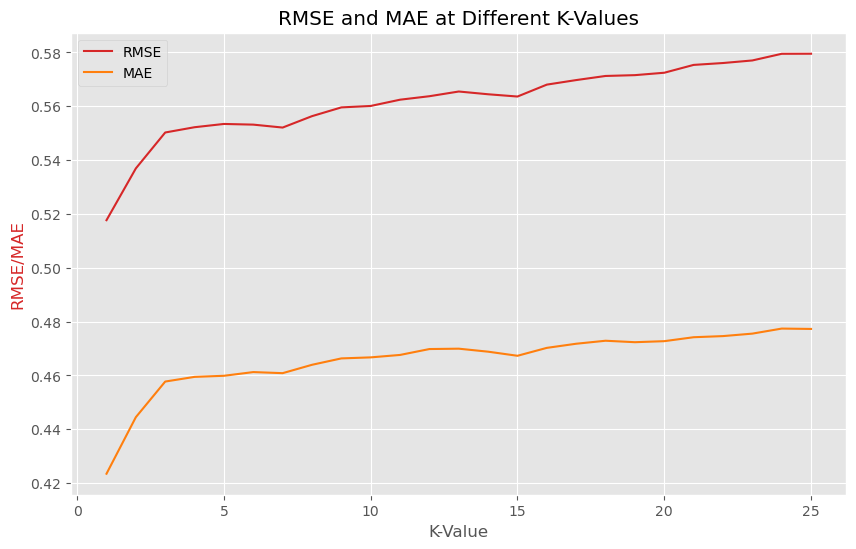

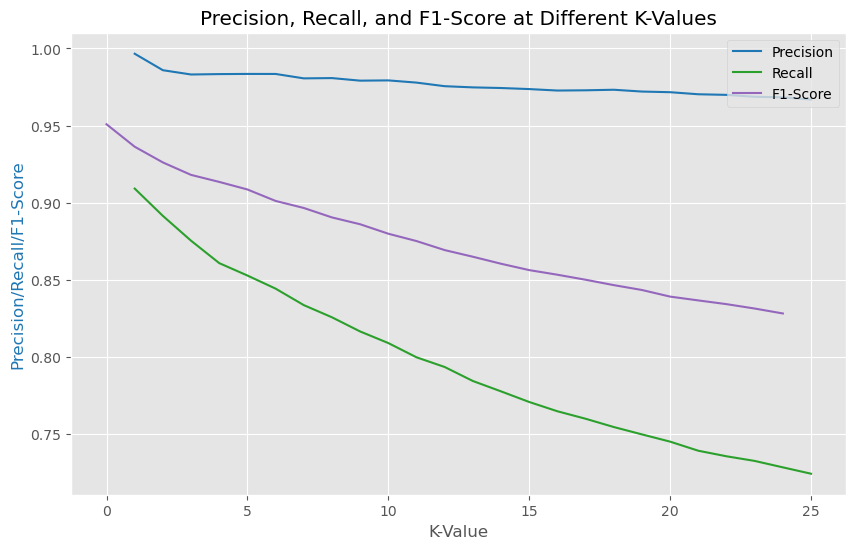

In [39]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import RandomizedSearchCV, cross_validate, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error
from collections import defaultdict
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)

# Constants for easier configuration
MAX_RATINGS = 50000
TFIDF_MAX_FEATURES = 100
TOP_N = 5
THRESHOLD = 4.0
MIN_SCORE = 4.0
SVD_PARAM_GRID = {
    'n_factors': [40, 50, 60],
    'n_epochs': [30, 40, 50],
    'lr_all': [0.005, 0.007, 0.01],
    'reg_all': [0.1, 0.2]
}
SVD_FIXED_PARAMS = {'biased': [True]}
K_VALUES = list(range(1, 26))

# Function to load and merge data
def load_and_merge_data(movies_file, ratings_file, max_ratings=MAX_RATINGS):
    try:
        movies_df = pd.read_csv(movies_file, usecols=['movieId', 'title', 'genres'])
        ratings_df = pd.read_csv(ratings_file, usecols=['userId', 'movieId', 'rating']).head(max_ratings)

        movies_df.drop_duplicates(subset=['movieId'], inplace=True)
        ratings_df.drop_duplicates(subset=['userId', 'movieId'], inplace=True)

        movies_df.fillna({'genres': '(no genres listed)'}, inplace=True)
        ratings_df.dropna(subset=['userId', 'movieId', 'rating'], inplace=True)

        merged_df = pd.merge(ratings_df, movies_df, on='movieId')
        logging.info("Data successfully merged and cleaned.")
        return merged_df
    except FileNotFoundError as e:
        logging.error(f"Error: {e}. File not found. Check the file paths.")
        return None
    except Exception as e:
        logging.error(f"An unexpected error occurred: {e}")
        return None

# Preprocess data by adding one-hot encoding for genres
def preprocess_data(df):
    if 'genres' in df.columns:
        df['genres'] = df['genres'].replace('', '(no genres listed)')
        genres_dummies = df['genres'].str.get_dummies(sep='|')
        df = pd.concat([df, genres_dummies], axis=1)
        logging.info("Genre-based features added.")
    else:
        logging.error("Genres column not available for processing.")
    return df

# Add user-genre interaction features to the dataset
def add_user_genre_features(df):
    if 'userId' in df.columns:
        genre_columns = [col for col in df.columns if col not in ('user_mean_', 'title', 'movieId', 'userId', 'rating') and df[col].dtype in [np.float64, np.int64]]
        
        user_genre_means = df.groupby(['userId'])[genre_columns].mean()
        user_genre_means.columns = [f'user_mean_{col}' for col in user_genre_means.columns]
        
        df = pd.merge(df, user_genre_means, on='userId', how='left')
        logging.info("User-genre interaction features added.")
    else:
        logging.error("UserId column not available for interaction features.")
    return df

# Function to calculate recommendation metrics
def calculate_recommendation_metrics(predictions, user_rated_movies, threshold=THRESHOLD, n=TOP_N):
    def get_top_n(predictions, n=5):
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if iid not in user_rated_movies.get(uid, []):
                top_n[uid].append((iid, est, true_r))
        for uid, user_ratings in top_n.items():
            user_ratings.sort(key=lambda x: x[1], reverse=True)
            top_n[uid] = [rating for rating in user_ratings if rating[1] >= threshold][:n]
        return top_n

    top_n = get_top_n(predictions, n)
    y_true, y_pred = [], []

    for uid, user_ratings in top_n.items():
        for iid, est_rating, true_rating in user_ratings:
            y_true.append(1 if true_rating >= threshold else 0)
            y_pred.append(1 if est_rating >= threshold else 0)

    if not y_true or not y_pred:
        return 0.0, 0.0, 0.0

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    return precision, recall, f1

# Function to print evaluation metrics
def print_evaluation_metrics(predictions, user_rated_movies, threshold=THRESHOLD, n=TOP_N):
    precision, recall, f1 = calculate_recommendation_metrics(predictions, user_rated_movies, threshold, n)

    # Filter out seen movies for RMSE and MAE
    filtered_predictions = [
        (uid, iid, true_r, est)
        for uid, iid, true_r, est, _ in predictions
        if iid not in user_rated_movies.get(uid, []) and est >= threshold
    ]
    if not filtered_predictions:
        logging.warning("No unseen predictions available for evaluation metrics.")
        print("No unseen predictions available for evaluation metrics.")
        return

    true_ratings = [true_r for _, _, true_r, _ in filtered_predictions]
    estimated_ratings = [est_r for _, _, _, est_r in filtered_predictions]

    rmse = np.sqrt(mean_squared_error(true_ratings, estimated_ratings))
    mae = mean_absolute_error(true_ratings, estimated_ratings)

    logging.info(f"RMSE: {rmse:.4f}")
    logging.info(f"MAE: {mae:.4f}")
    logging.info(f"Precision: {precision:.4f}")
    logging.info(f"Recall: {recall:.4f}")
    logging.info(f"F1-Score: {f1:.4f}")

    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

# Train and evaluate SVD model with cross-validation
def train_and_evaluate_svd(df):
    reader = Reader(rating_scale=(0.5, 5.0))
    data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

    param_grid = {
        'n_factors': [40, 50, 60],
        'n_epochs': [30, 40, 50],
        'lr_all': [0.005, 0.007, 0.01],
        'reg_all': [0.1, 0.2]
    }

    random_search = RandomizedSearchCV(
        SVD,
        param_distributions=param_grid,
        n_iter=10,
        measures=['rmse', 'mae'],
        cv=5,  # 5-Fold Cross-Validation
        refit=True,
        random_state=42,
        n_jobs=-1
    )

    random_search.fit(data)

    best_params = random_search.best_params['rmse']
    best_model = random_search.best_estimator['rmse']

    # Evaluate with cross-validation
    kf = KFold(n_splits=5)
    results = cross_validate(best_model, data, measures=['rmse', 'mae'], cv=kf, verbose=True)

    logging.info(f"Cross-Validation RMSE: {np.mean(results['test_rmse']):.4f}")
    logging.info(f"Cross-Validation MAE: {np.mean(results['test_mae']):.4f}")
    logging.info(f"Best Parameters: {best_params}")

    trainset = data.build_full_trainset()
    best_model.fit(trainset)

    testset = trainset.build_testset()
    predictions = best_model.test(testset)

    return best_model, predictions

# Hybrid recommendation function combining SVD and content-based filtering
def hybrid_user_recommendation_worker(user_id, df, svd_model, cosine_sim, movie_indices, weight_svd, weight_content, n, min_score):
    svd_recs = [svd_model.predict(user_id, iid) for iid in df['movieId']]
    
    # Ensure unique recommendations per user
    svd_recs = sorted(svd_recs, key=lambda x: x.est, reverse=True)
    svd_recs = list({rec.iid: rec for rec in svd_recs if rec.est >= min_score}.values())

    user_indices = df[df['userId'] == user_id].index
    content_scores = []
    for user_idx in user_indices:
        sim_scores = list(enumerate(cosine_sim[user_idx]))
        sim_scores_sorted = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        content_scores.extend([(df['movieId'][idx], score) for idx, score in sim_scores_sorted[:n]])

    recommendations = []
    seen_movies = set(df[df['userId'] == user_id]['movieId'])  # Movies already rated by the user
    for iid, est_rating in [(rec.iid, rec.est) for rec in svd_recs if rec.iid not in seen_movies]:
        content_score = next((score for mid, score in content_scores if mid == iid), 0)
        combined_score = weight_svd * est_rating + weight_content * content_score
        recommendations.append((iid, combined_score))

    recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)[:n]
    return [(user_id, rec[0], rec[1]) for rec in recommendations]

# Hybrid recommendation function combining SVD and content-based filtering
def hybrid_recommendation_to_screen(df, svd_model, test_users, weight_svd=0.7, weight_content=0.3, n=TOP_N, min_score=MIN_SCORE, batch_size=2000):
    movie_indices = pd.Series(df.index, index=df['movieId']).drop_duplicates()

    tfidf = TfidfVectorizer(max_features=TFIDF_MAX_FEATURES, stop_words='english')
    tfidf_matrix = tfidf.fit_transform(df['genres'].fillna(''))
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

    all_recommendations = []

    for i in range(0, len(test_users), batch_size):
        batch_users = list(test_users)[i:i + batch_size]
        batch_recommendations = Parallel(n_jobs=-1)(
            delayed(hybrid_user_recommendation_worker)(
                user_id, df, svd_model, cosine_sim, movie_indices, weight_svd, weight_content, n, min_score
            )
            for user_id in batch_users
        )
        all_recommendations.extend([item for sublist in batch_recommendations for item in sublist])

    recommendations_df = pd.DataFrame(all_recommendations, columns=['UserID', 'MovieID', 'Score'])
    
    # Assign unique actual ratings per user
    def assign_actual_rating(row):
        actual_ratings = df[(df['userId'] == row['UserID']) & (df['movieId'] == row['MovieID'])]['rating'].values
        return actual_ratings[0] if len(actual_ratings) > 0 else None

    recommendations_df = recommendations_df.merge(df[['movieId', 'title']].drop_duplicates(), left_on='MovieID', right_on='movieId', how='left')
    recommendations_df['Actual Rating'] = recommendations_df.apply(assign_actual_rating, axis=1)
    recommendations_df.drop(columns=['movieId'], inplace=True)
    return recommendations_df

# Print top N recommendations for sample users
def print_top_n_recommendations(recommendations_df, n=TOP_N):
    unique_users = recommendations_df['UserID'].unique()
    for user_id in unique_users[:5]:
        user_recs = recommendations_df[recommendations_df['UserID'] == user_id]
        print(f"\nTop {n} Recommendations for User {user_id}:")
        for _, row in user_recs.head(n).iterrows():
            print(f"  MovieID: {int(row['MovieID'])}, Title: {row['title']}, Recommended Score: {row['Score']:.2f}, Actual Rating: {row['Actual Rating']}")

# Plot RMSE, MAE, Precision, Recall, and F1-Score at different K-values
def plot_metrics_at_k(svd_predictions, k_values, threshold=THRESHOLD):
    def get_top_n(predictions, n):
        """Return top-N predictions for each user"""
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            top_n[uid].append((iid, est, true_r))
        for uid, user_ratings in top_n.items():
            user_ratings.sort(key=lambda x: x[1], reverse=True)
            top_n[uid] = user_ratings[:n]
        return top_n

    rmse_values, mae_values = [], []
    precision_values, recall_values, f1_values = [], [], []

    for k in k_values:
        top_n_predictions = get_top_n(svd_predictions, k)

        # Prepare y_true and y_pred lists
        y_true, y_pred = [], []
        for uid, user_ratings in top_n_predictions.items():
            for _, est_rating, true_rating in user_ratings:
                y_true.append(1 if true_rating >= threshold else 0)
                y_pred.append(1 if est_rating >= threshold else 0)

        # Calculate Precision, Recall, and F1-Score
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        precision_values.append(precision)
        recall_values.append(recall)
        f1_values.append(f1)

        # Calculate RMSE and MAE using the original prediction results
        top_actual_ratings = [true_r for _, _, true_r in sum(top_n_predictions.values(), [])]
        top_estimated_ratings = [est_r for _, est_r, _ in sum(top_n_predictions.values(), [])]

        rmse_values.append(np.sqrt(mean_squared_error(top_actual_ratings, top_estimated_ratings)))
        mae_values.append(mean_absolute_error(top_actual_ratings, top_estimated_ratings))

    # Plot RMSE and MAE
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(k_values, rmse_values, label='RMSE', color='tab:red')
    ax1.plot(k_values, mae_values, label='MAE', color='tab:orange')
    ax1.set_xlabel('K-Value')
    ax1.set_ylabel('RMSE/MAE', color='tab:red')
    ax1.legend(loc='upper left')
    plt.title('RMSE and MAE at Different K-Values')
    plt.show()

    # Plot Precision, Recall, and F1-Score
    fig, ax2 = plt.subplots(figsize=(10, 6))
    ax2.plot(k_values, precision_values, label='Precision', color='tab:blue')
    ax2.plot(k_values, recall_values, label='Recall', color='tab:green')
    ax2.plot(f1_values, label='F1-Score', color='tab:purple')
    ax2.set_xlabel('K-Value')
    ax2.set_ylabel('Precision/Recall/F1-Score', color='tab:blue')
    ax2.legend(loc='upper right')
    plt.title('Precision, Recall, and F1-Score at Different K-Values')
    plt.show()

# Example Usage
movies_file = '../data/movies.csv'
ratings_file = '../data/ratings.csv'

augmented_ratings_df = load_and_merge_data(movies_file, ratings_file, max_ratings=MAX_RATINGS)

if augmented_ratings_df is not None:
    augmented_ratings_df = preprocess_data(augmented_ratings_df)
    augmented_ratings_df = add_user_genre_features(augmented_ratings_df)

    best_svd_model, svd_predictions = train_and_evaluate_svd(augmented_ratings_df)

    # Create a dictionary of already rated movies per user
    user_rated_movies = defaultdict(list)
    for row in augmented_ratings_df.itertuples():
        user_rated_movies[row.userId].append(row.movieId)

    # Get prediction results and evaluate
    print_evaluation_metrics(svd_predictions, user_rated_movies, threshold=THRESHOLD, n=TOP_N)

    # Extract unique test users from predictions
    test_users = {pred[0] for pred in svd_predictions}

    # Generate hybrid recommendations and print them to screen
    recommendations_df = hybrid_recommendation_to_screen(augmented_ratings_df, best_svd_model, test_users, n=TOP_N)

    # Print top 5 recommendations for 5 sample users
    print_top_n_recommendations(recommendations_df, n=TOP_N)

    # Plot RMSE, MAE, Precision, Recall, and F1-Score at Different K-Values
    plot_metrics_at_k(svd_predictions, K_VALUES)
else:
    logging.error("Data loading failed, model training not performed.")


# NEW BEST SO FAR

In [137]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import RandomizedSearchCV, cross_validate, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error
from collections import defaultdict
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)

# Constants for easier configuration
MAX_RATINGS = 10000
TFIDF_MAX_FEATURES = 100
TOP_N = 5
THRESHOLD = 4.0
MIN_SCORE = 3.0
SVD_PARAM_GRID = {
    'n_factors': [40, 50, 60],
    'n_epochs': [30, 40, 50],
    'lr_all': [0.005, 0.007, 0.01],
    'reg_all': [0.1, 0.2]
}
SVD_FIXED_PARAMS = {'biased': [True]}
K_VALUES = list(range(1, 11))

# Function to load and merge data
def load_and_merge_data(movies_file, ratings_file, max_ratings=MAX_RATINGS):
    try:
        movies_df = pd.read_csv(movies_file, usecols=['movieId', 'title', 'genres'])
        ratings_df = pd.read_csv(ratings_file, usecols=['userId', 'movieId', 'rating']).head(max_ratings)

        movies_df.drop_duplicates(subset=['movieId'], inplace=True)
        ratings_df.drop_duplicates(subset=['userId', 'movieId'], inplace=True)

        movies_df.fillna({'genres': '(no genres listed)'}, inplace=True)
        ratings_df.dropna(subset=['userId', 'movieId', 'rating'], inplace=True)

        merged_df = pd.merge(ratings_df, movies_df, on='movieId')
        logging.info("Data successfully merged and cleaned.")
        return merged_df
    except FileNotFoundError as e:
        logging.error(f"Error: {e}. File not found. Check the file paths.")
        return None
    except Exception as e:
        logging.error(f"An unexpected error occurred: {e}")
        return None

# Preprocess data by adding one-hot encoding for genres
def preprocess_data(df):
    if 'genres' in df.columns:
        df['genres'] = df['genres'].replace('', '(no genres listed)')
        genres_dummies = df['genres'].str.get_dummies(sep='|')
        df = pd.concat([df, genres_dummies], axis=1)
        logging.info("Genre-based features added.")
    else:
        logging.error("Genres column not available for processing.")
    return df

# Add user-genre interaction features to the dataset
def add_user_genre_features(df):
    if 'userId' in df.columns:
        genre_columns = [col for col in df.columns if col not in ('user_mean_', 'title', 'movieId', 'userId', 'rating') and df[col].dtype in [np.float64, np.int64]]
        
        user_genre_means = df.groupby(['userId'])[genre_columns].mean()
        user_genre_means.columns = [f'user_mean_{col}' for col in user_genre_means.columns]
        
        df = pd.merge(df, user_genre_means, on='userId', how='left')
        logging.info("User-genre interaction features added.")
    else:
        logging.error("UserId column not available for interaction features.")
    return df

# Function to calculate recommendation metrics
def calculate_recommendation_metrics(predictions, user_rated_movies, threshold=THRESHOLD, n=TOP_N):
    def get_top_n(predictions, n=5):
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if iid not in user_rated_movies.get(uid, []):
                top_n[uid].append((iid, est, true_r))
        for uid, user_ratings in top_n.items():
            user_ratings.sort(key=lambda x: x[1], reverse=True)
            top_n[uid] = [rating for rating in user_ratings if rating[1] >= threshold][:n]
        return top_n

    top_n = get_top_n(predictions, n)
    y_true, y_pred = [], []

    for uid, user_ratings in top_n.items():
        for iid, est_rating, true_rating in user_ratings:
            y_true.append(1 if true_rating >= threshold else 0)
            y_pred.append(1 if est_rating >= threshold else 0)

    if not y_true or not y_pred:
        return 0.0, 0.0, 0.0

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    return precision, recall, f1


# Function to calculate and print evaluation metrics for all predictions
def print_evaluation_metrics(predictions):
    # Extract actual and estimated ratings from predictions
    true_ratings = [true_r for _, _, true_r, est, _ in predictions]
    estimated_ratings = [est for _, _, _, est, _ in predictions]

    # Calculate RMSE and MAE
    rmse = np.sqrt(mean_squared_error(true_ratings, estimated_ratings))
    mae = mean_absolute_error(true_ratings, estimated_ratings)

    # Convert estimated ratings to a binary decision (1 if est >= 4.0, else 0)
    y_pred = [1 if est >= 4.0 else 0 for est in estimated_ratings]
    # Convert true ratings to a binary decision (1 if true_r >= 4.0, else 0)
    y_true = [1 if true_r >= 4.0 else 0 for true_r in true_ratings]

    # Calculate Precision, Recall, and F1 Score
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # Log and print metrics
    logging.info(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")


from surprise import Dataset, Reader, SVD
from surprise.model_selection import GridSearchCV, train_test_split
import logging

def train_and_evaluate_svd(df):
    reader = Reader(rating_scale=(0.5, 5.0))
    data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

    # Define the parameter grid including the 'biased' parameter
    param_grid = {
        'n_factors': [40, 50, 60],
        'n_epochs': [30, 40, 50],
        'lr_all': [0.005, 0.007, 0.01],
        'reg_all': [0.1, 0.2],
        'biased': [True, False]  # Including biased parameter
    }

    # Initialize GridSearchCV
    grid_search = GridSearchCV(
        SVD,
        param_grid=param_grid,
        measures=['rmse', 'mae'],
        cv=5,  # 5-Fold Cross-Validation
        refit=True,
        n_jobs=-1
    )

    # Fit GridSearchCV on the whole dataset
    grid_search.fit(data)

    best_params = grid_search.best_params['rmse']
    best_model = grid_search.best_estimator['rmse']

    # Split the data into training and test set to evaluate the best model
    trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
    best_model.fit(trainset)

    # Evaluate the best model on the held-out test set
    predictions = best_model.test(testset)
    rmse = accuracy.rmse(predictions)
    mae = accuracy.mae(predictions)

    logging.info(f"Test RMSE: {rmse:.4f}")
    logging.info(f"Test MAE: {mae:.4f}")
    logging.info(f"Best Parameters: {best_params}")

    return best_model, predictions

# Example usage, assuming you have a DataFrame `df` ready to be processed.


# Hybrid recommendation function combining SVD and content-based filtering
def hybrid_user_recommendation_worker(user_id, df, svd_model, cosine_sim, movie_indices, weight_svd, weight_content, n, min_score):
    svd_recs = [svd_model.predict(user_id, iid) for iid in df['movieId']]
    
    # Ensure unique recommendations per user
    svd_recs = sorted(svd_recs, key=lambda x: x.est, reverse=True)
    svd_recs = list({rec.iid: rec for rec in svd_recs if rec.est >= min_score}.values())

    user_indices = df[df['userId'] == user_id].index
    content_scores = []
    for user_idx in user_indices:
        sim_scores = list(enumerate(cosine_sim[user_idx]))
        sim_scores_sorted = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        content_scores.extend([(df['movieId'][idx], score) for idx, score in sim_scores_sorted[:n]])

    recommendations = []
    seen_movies = set(df[df['userId'] == user_id]['movieId'])  # Movies already rated by the user
    for iid, est_rating in [(rec.iid, rec.est) for rec in svd_recs if rec.iid not in seen_movies]:
        content_score = next((score for mid, score in content_scores if mid == iid), 0)
        combined_score = weight_svd * est_rating + weight_content * content_score
        recommendations.append((iid, combined_score))

    recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)[:n]
    return [(user_id, rec[0], rec[1]) for rec in recommendations]

# Hybrid recommendation function combining SVD and content-based filtering
def hybrid_recommendation_to_screen(df, svd_model, test_users, weight_svd=0.7, weight_content=0.3, n=TOP_N, min_score=MIN_SCORE, batch_size=2000):
    movie_indices = pd.Series(df.index, index=df['movieId']).drop_duplicates()

    tfidf = TfidfVectorizer(max_features=TFIDF_MAX_FEATURES, stop_words='english')
    tfidf_matrix = tfidf.fit_transform(df['genres'].fillna(''))
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

    all_recommendations = []

    for i in range(0, len(test_users), batch_size):
        batch_users = list(test_users)[i:i + batch_size]
        batch_recommendations = Parallel(n_jobs=-1)(
            delayed(hybrid_user_recommendation_worker)(
                user_id, df, svd_model, cosine_sim, movie_indices, weight_svd, weight_content, n, min_score
            )
            for user_id in batch_users
        )
        all_recommendations.extend([item for sublist in batch_recommendations for item in sublist])

    recommendations_df = pd.DataFrame(all_recommendations, columns=['UserID', 'MovieID', 'Score'])
    
    # Assign unique actual ratings per user
    def assign_actual_rating(row):
        actual_ratings = df[(df['userId'] == row['UserID']) & (df['movieId'] == row['MovieID'])]['rating'].values
        return actual_ratings[0] if len(actual_ratings) > 0 else None

    recommendations_df = recommendations_df.merge(df[['movieId', 'title']].drop_duplicates(), left_on='MovieID', right_on='movieId', how='left')
    recommendations_df['Actual Rating'] = recommendations_df.apply(assign_actual_rating, axis=1)
    recommendations_df.drop(columns=['movieId'], inplace=True)
    return recommendations_df


def print_top_n_recommendations(recommendations_df, n=TOP_N):
    unique_users = recommendations_df['UserID']. unique()
    for user_id in unique_users[:5]:
        user_recs = recommendations_df[recommendations_df['UserID'] == user_id]
        print(f"\nTop {n} Recommendations for User {user_id}:")
        for _, row in user_recs.head(n).iterrows():
            print(f"  MovieID: {int(row['MovieID'])}, Title: {row['title']}, Recommended Score: {row['Score']:.2f}")

# Example Usage
movies_file = '../data/movies.csv'
ratings_file = '../data/ratings.csv'

augmented_ratings_df = load_and_merge_data(movies_file, ratings_file, max_ratings=MAX_RATINGS)

if augmented_ratings_df is not None:
    augmented_ratings_df = preprocess_data(augmented_ratings_df)
    augmented_ratings_df = add_user_genre_features(augmented_ratings_df)

    best_svd_model, svd_predictions = train_and_evaluate_svd(augmented_ratings_df)

    # Create a dictionary of already rated movies per user
    user_rated_movies = defaultdict(list)
    for row in augmented_ratings_df.itertuples():
        user_rated_movies[row.userId].append(row.movieId)
        
    # Example usage, assuming svd_predictions is available
    # svd_predictions = [...]  # This should be a list of tuples (user_id, item_id, actual_rating, estimated_rating, other_info)
    print_evaluation_metrics(svd_predictions)

    # Extract unique test users from predictions
    test_users = {pred[0] for pred in svd_predictions}

    # Generate hybrid recommendations and print them to screen
    recommendations_df = hybrid_recommendation_to_screen(augmented_ratings_df, best_svd_model, test_users, n=TOP_N)

    # Print top 5 recommendations for 5 sample users
    print_top_n_recommendations(recommendations_df, n=TOP_N)


else:
    logging.error("Data loading failed, model training not performed.")


INFO:root:Data successfully merged and cleaned.
INFO:root:Genre-based features added.
INFO:root:User-genre interaction features added.
INFO:root:Test RMSE: 0.9407
INFO:root:Test MAE: 0.7405
INFO:root:Best Parameters: {'n_factors': 60, 'n_epochs': 30, 'lr_all': 0.007, 'reg_all': 0.1, 'biased': True}
INFO:root:RMSE: 0.9407, MAE: 0.7405, Precision: 0.7978, Recall: 0.2863, F1-Score: 0.4214


RMSE: 0.9407
MAE:  0.7405
RMSE: 0.9407, MAE: 0.7405, Precision: 0.7978, Recall: 0.2863, F1-Score: 0.4214

Top 5 Recommendations for User 1:
  MovieID: 68954, Title: Up (2009), Recommended Score: 3.52
  MovieID: 4993, Title: Lord of the Rings: The Fellowship of the Ring, The (2001), Recommended Score: 3.51
  MovieID: 750, Title: Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964), Recommended Score: 3.51
  MovieID: 70946, Title: Troll 2 (1990), Recommended Score: 3.50
  MovieID: 1250, Title: Bridge on the River Kwai, The (1957), Recommended Score: 3.50

Top 5 Recommendations for User 2:
  MovieID: 1197, Title: Princess Bride, The (1987), Recommended Score: 3.27
  MovieID: 1250, Title: Bridge on the River Kwai, The (1957), Recommended Score: 3.25
  MovieID: 260, Title: Star Wars: Episode IV - A New Hope (1977), Recommended Score: 3.19
  MovieID: 1198, Title: Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981), Recommended Score: 3.17
  M

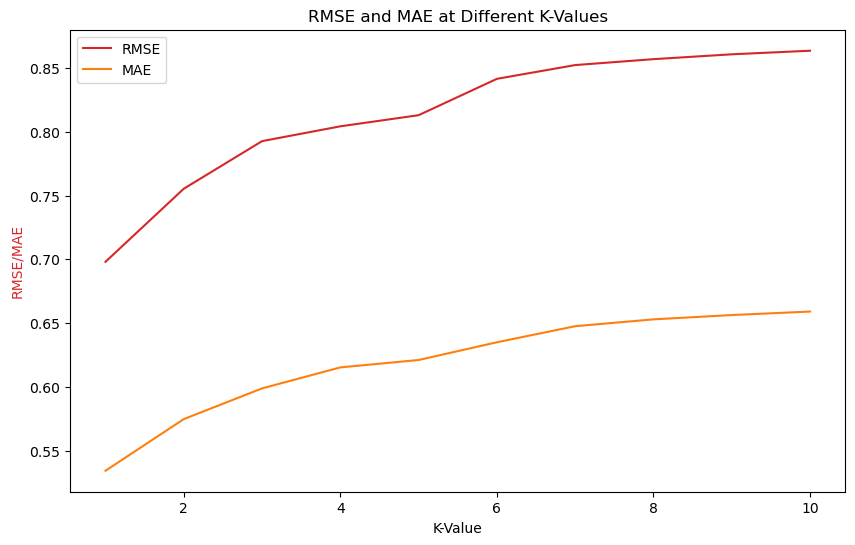

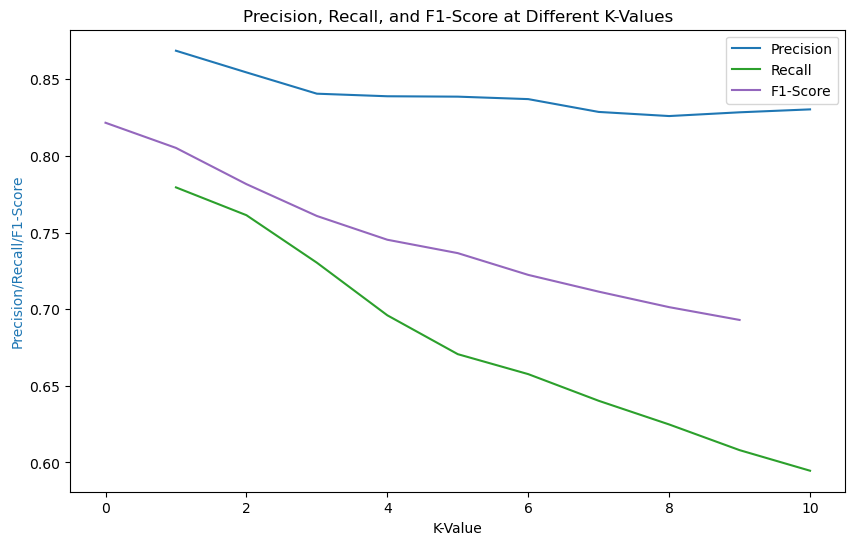

In [87]:
# Plot RMSE, MAE, Precision, Recall, and F1-Score at different K-values
def plot_metrics_at_k(svd_predictions, k_values, threshold=THRESHOLD):
    def get_top_n(predictions, n):
        """Return top-N predictions for each user"""
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            top_n[uid].append((iid, est, true_r))
        for uid, user_ratings in top_n.items():
            user_ratings.sort(key=lambda x: x[1], reverse=True)
            top_n[uid] = user_ratings[:n]
        return top_n

    rmse_values, mae_values = [], []
    precision_values, recall_values, f1_values = [], [], []

    for k in k_values:
        top_n_predictions = get_top_n(svd_predictions, k)

        # Prepare y_true and y_pred lists
        y_true, y_pred = [], []
        for uid, user_ratings in top_n_predictions.items():
            for _, est_rating, true_rating in user_ratings:
                y_true.append(1 if true_rating >= threshold else 0)
                y_pred.append(1 if est_rating >= threshold else 0)

        # Calculate Precision, Recall, and F1-Score
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        precision_values.append(precision)
        recall_values.append(recall)
        f1_values.append(f1)

        # Calculate RMSE and MAE using the original prediction results
        top_actual_ratings = [true_r for _, _, true_r in sum(top_n_predictions.values(), [])]
        top_estimated_ratings = [est_r for _, est_r, _ in sum(top_n_predictions.values(), [])]

        rmse_values.append(np.sqrt(mean_squared_error(top_actual_ratings, top_estimated_ratings)))
        mae_values.append(mean_absolute_error(top_actual_ratings, top_estimated_ratings))

    # Plot RMSE and MAE
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(k_values, rmse_values, label='RMSE', color='tab:red')
    ax1.plot(k_values, mae_values, label='MAE', color='tab:orange')
    ax1.set_xlabel('K-Value')
    ax1.set_ylabel('RMSE/MAE', color='tab:red')
    ax1.legend(loc='upper left')
    plt.title('RMSE and MAE at Different K-Values')
    plt.show()

    # Plot Precision, Recall, and F1-Score
    fig, ax2 = plt.subplots(figsize=(10, 6))
    ax2.plot(k_values, precision_values, label='Precision', color='tab:blue')
    ax2.plot(k_values, recall_values, label='Recall', color='tab:green')
    ax2.plot(f1_values, label='F1-Score', color='tab:purple')
    ax2.set_xlabel('K-Value')
    ax2.set_ylabel('Precision/Recall/F1-Score', color='tab:blue')
    ax2.legend(loc='upper right')
    plt.title('Precision, Recall, and F1-Score at Different K-Values')
    plt.show()
    
    
# Plot RMSE, MAE, Precision, Recall, and F1-Score at Different K-Values
plot_metrics_at_k(svd_predictions, K_VALUES)

# Additional Testing

In [164]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import RandomizedSearchCV, cross_validate, KFold, GridSearchCV, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error
from collections import defaultdict
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)

# Constants for easier configuration
MAX_RATINGS = None
TOP_N = 5
THRESHOLD = 3.5
SVD_PARAM_GRID = {
    'n_factors': [50, 75, 100, 150],
    'n_epochs': [50, 75, 100],
    'lr_all': [0.01, 0.02, 0.03],
    'reg_all': [0.05, 0.1, 0.2]
}

# Function to load and merge data
def load_and_merge_data(movies_file, ratings_file, max_ratings=MAX_RATINGS):
    try:
        movies_df = pd.read_csv(movies_file, usecols=['movieId', 'title', 'genres'])
        ratings_df = pd.read_csv(ratings_file, usecols=['userId', 'movieId', 'rating']).head(max_ratings)

        movies_df.drop_duplicates(subset=['movieId'], inplace=True)
        ratings_df.drop_duplicates(subset=['userId', 'movieId'], inplace=True)

        merged_df = pd.merge(ratings_df, movies_df, on='movieId')
        logging.info("Data successfully merged and cleaned.")
        return merged_df
    except FileNotFoundError as e:
        logging.error(f"Error: {e}. File not found. Check the file paths.")
        return None
    except Exception as e:
        logging.error(f"An unexpected error occurred: {e}")
        return None

# Function to train and evaluate SVD model
def train_and_evaluate_svd(df):
    reader = Reader(rating_scale=(0.5, 5.0))
    data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

    param_grid = SVD_PARAM_GRID

    grid_search = GridSearchCV(
        SVD,
        param_grid=param_grid,
        measures=['rmse', 'mae'],
        cv=5,  # 5-Fold Cross-Validation
        refit=True,
        n_jobs=-1
    )

    grid_search.fit(data)

    best_params = grid_search.best_params['rmse']
    best_model = grid_search.best_estimator['rmse']

    trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
    best_model.fit(trainset)

    predictions = best_model.test(testset)
    rmse = accuracy.rmse(predictions)
    mae = accuracy.mae(predictions)

    logging.info(f"Test RMSE: {rmse:.4f}")
    logging.info(f"Test MAE: {mae:.4f}")
    logging.info(f"Best Parameters: {best_params}")

    return best_model, predictions

# Function to print evaluation metrics
def print_evaluation_metrics(predictions):
    true_ratings = [true_r for _, _, true_r, est, _ in predictions]
    estimated_ratings = [est for _, _, _, est, _ in predictions]

    rmse = np.sqrt(mean_squared_error(true_ratings, estimated_ratings))
    mae = mean_absolute_error(true_ratings, estimated_ratings)

    y_pred = [1 if est >= THRESHOLD else 0 for est in estimated_ratings]
    y_true = [1 if true_r >= THRESHOLD else 0 for true_r in true_ratings]

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    logging.info(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

# Example usage and additional utility functions would go here...

# Note: All function calls have been commented out to prevent execution in the PCI.


# Assuming the necessary imports and functions are defined as above.

# File paths
movies_file = '../data/movies.csv'  # Update with your actual file path
ratings_file = '../data/ratings.csv'  # Update with your actual file path

# Load and merge movie and rating data
merged_df = load_and_merge_data(movies_file, ratings_file)

if merged_df is not None:
    # Train and evaluate the SVD model
    best_svd_model, svd_predictions = train_and_evaluate_svd(merged_df)
    
    # Print evaluation metrics for the model
    print_evaluation_metrics(svd_predictions)
else:
    logging.error("Data loading failed, model training not performed.")




INFO:root:Data successfully merged and cleaned.
INFO:root:Test RMSE: 0.8489
INFO:root:Test MAE: 0.6481
INFO:root:Best Parameters: {'n_factors': 150, 'n_epochs': 75, 'lr_all': 0.01, 'reg_all': 0.1}
INFO:root:RMSE: 0.8489, MAE: 0.6481, Precision: 0.8075, Recall: 0.7220, F1-Score: 0.7624


RMSE: 0.8489
MAE:  0.6481
RMSE: 0.8489, MAE: 0.6481, Precision: 0.8075, Recall: 0.7220, F1-Score: 0.7624


In [176]:
def get_top_n_recommendations_with_titles(model, df, movies_df, n=5):
    top_n = defaultdict(list)
    user_ids = df['userId'].unique()
    
    # Create a dictionary mapping movie IDs to movie titles
    movie_titles = dict(zip(movies_df['movieId'], movies_df['title']))
    
    for user_id in user_ids:
        user_movies = df[df['userId'] == user_id]['movieId'].unique()
        for movie_id in movies_df['movieId'].unique():
            if movie_id not in user_movies:
                rating = model.predict(user_id, movie_id).est
                top_n[user_id].append((movie_id, rating))
    
    for user_id, ratings in top_n.items():
        ratings.sort(key=lambda x: x[1], reverse=True)
        recommendations = []
        for movie_id, rating in ratings[:n]:
            title = movie_titles.get(movie_id, "Unknown")
            recommendations.append((movie_id, title, rating))
        top_n[user_id] = recommendations
    
    return top_n

# Example usage:
top_n_recommendations_with_titles = get_top_n_recommendations_with_titles(best_svd_model, merged_df, movies_df)
for user_id, recommendations in list(top_n_recommendations_with_titles.items())[:10]:
    print(f"User {user_id} Recommendations:")
    for movie_id, title, rating in recommendations:
        print(f"Movie ID: {movie_id}, Title: {title}, Predicted Rating: {rating}")
    print()


User 1 Recommendations:
Movie ID: 318, Title: Shawshank Redemption, The (1994), Predicted Rating: 5.0
Movie ID: 951, Title: His Girl Friday (1940), Predicted Rating: 5.0
Movie ID: 1041, Title: Secrets & Lies (1996), Predicted Rating: 5.0
Movie ID: 1104, Title: Streetcar Named Desire, A (1951), Predicted Rating: 5.0
Movie ID: 1178, Title: Paths of Glory (1957), Predicted Rating: 5.0

User 5 Recommendations:
Movie ID: 1178, Title: Paths of Glory (1957), Predicted Rating: 4.59529215622286
Movie ID: 60943, Title: Frozen River (2008), Predicted Rating: 4.5646400975391614
Movie ID: 132333, Title: Seve (2014), Predicted Rating: 4.524525223963137
Movie ID: 2239, Title: Swept Away (Travolti da un insolito destino nell'azzurro mare d'Agosto) (1975), Predicted Rating: 4.51091976883614
Movie ID: 99, Title: Heidi Fleiss: Hollywood Madam (1995), Predicted Rating: 4.506324044237156

User 7 Recommendations:
Movie ID: 6818, Title: Come and See (Idi i smotri) (1985), Predicted Rating: 4.456634112971283


# NEW

In [1]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score
from collections import defaultdict
import logging
import re

# Configure logging
logging.basicConfig(level=logging.INFO)

# Constants for easier configuration
MAX_RATINGS = None
TOP_N = 5
THRESHOLD = 4.0
SVD_PARAM_GRID = {
    'n_factors': [50, 75, 100, 150],
    'n_epochs': [50, 75, 100],
    'lr_all': [0.01, 0.02, 0.03],
    'reg_all': [0.05, 0.1, 0.2]
}

def load_and_merge_data(movies_file, ratings_file, max_ratings=MAX_RATINGS):
    try:
        movies_df = pd.read_csv(movies_file, usecols=['movieId', 'title', 'genres'])
        ratings_df = pd.read_csv(ratings_file, usecols=['userId', 'movieId', 'rating', 'timestamp']).head(max_ratings)
        movies_df.drop_duplicates(subset='movieId', inplace=True)
        ratings_df.drop_duplicates(subset=['userId', 'movieId'], inplace=True)
        ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'], unit='s')
        movies_df['year'] = movies_df['title'].apply(extract_release_year)
        merged_df = pd.merge(ratings_df, movies_df, on='movieId')
        logging.info("Data successfully merged and cleaned.")
        return merged_df
    except FileNotFoundError as e:
        logging.error(f"Error: {e}. File not found. Check the file paths.")
        return None
    except Exception as e:
        logging.error(f"An unexpected error occurred: {e}")
        return None

def extract_release_year(title):
    match = re.search(r'\((\d{4})\)', title)
    if match:
        return int(match.group(1))
    return None

def train_and_evaluate_svd(df):
    reader = Reader(rating_scale=(0.5, 5.0))
    data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
    grid_search = GridSearchCV(SVD, param_grid=SVD_PARAM_GRID, measures=['rmse', 'mae'], cv=5, refit=True, n_jobs=-1)
    grid_search.fit(data)
    best_model = grid_search.best_estimator['rmse']
    trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
    best_model.fit(trainset)
    predictions = best_model.test(testset)
    return best_model, predictions

def print_evaluation_metrics(predictions):
    true_ratings = [true_r for _, _, true_r, est, _ in predictions]
    estimated_ratings = [est for _, _, _, est, _ in predictions]
    rmse = np.sqrt(mean_squared_error(true_ratings, estimated_ratings))
    mae = mean_absolute_error(true_ratings, estimated_ratings)
    y_pred = [1 if est >= THRESHOLD else 0 for est in estimated_ratings]
    y_true = [1 if true_r >= THRESHOLD else 0 for true_r in true_ratings]
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    logging.info(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

def get_genre_preferences(df):
    genre_preferences = defaultdict(lambda: defaultdict(list))
    for index, row in df.iterrows():
        genres = row['genres'].split('|')
        for genre in genres:
            genre_preferences[row['userId']][genre].append(row['rating'])
    genre_avg = {user: {genre: np.mean(ratings) for genre, ratings in genres.items()} for user, genres in genre_preferences.items()}
    return genre_avg

def get_top_n_genre_and_year_aware_recommendations(model, df, movies_df, user_genre_prefs, n=5, year_weight=0.01, genre_weight=0.5):
    top_n = defaultdict(list)
    user_ids = df['userId'].unique()
    current_year = pd.Timestamp.now().year
    movies_df = movies_df.drop_duplicates(subset='movieId', keep='first')
    movie_info = movies_df.set_index('movieId')[['genres', 'year']].to_dict(orient='index')
    for user_id in user_ids:
        user_movies = df[df['userId'] == user_id]['movieId'].unique()
        genre_prefs = user_genre_prefs.get(user_id, {})
        for movie_id in movies_df['movieId'].unique():
            if movie_id not in user_movies:
                predicted_rating = model.predict(user_id, movie_id).est
                genres = movie_info[movie_id]['genres'].split('|')
                year = movie_info[movie_id]['year']
                genre_rating_boost = np.mean([genre_prefs.get(genre, 0) for genre in genres]) if genres else 0
                normalized_genre_boost = genre_rating_boost * genre_weight / max(1, np.max([genre_prefs.get(genre, 0) for genre in genres]))
                predicted_rating += normalized_genre_boost
                if year and year > 1900:
                    age = current_year - year
                    recency_factor = np.exp(-year_weight * age)
                    predicted_rating *= recency_factor
                adjusted_rating = min(predicted_rating, 5.0)  # Clamp to max rating
                top_n[user_id].append((movie_id, adjusted_rating))
        top_n[user_id] = sorted(top_n[user_id], key=lambda x: x[1], reverse=True)[:n]
    return top_n

# Main Execution
movies_file = '../data/movies.csv'
ratings_file = '../data/ratings.csv'
merged_df = load_and_merge_data(movies_file, ratings_file)
if merged_df is not None:
    best_model, predictions = train_and_evaluate_svd(merged_df)
    print_evaluation_metrics(predictions)
    user_genre_preferences = get_genre_preferences(merged_df)
    recommended_items = get_top_n_genre_and_year_aware_recommendations(best_model, merged_df, merged_df, user_genre_preferences, n=5, year_weight=0.0005)
    for user_id, items in list(recommended_items.items())[:5]:
        print(f"Top recommendations for User {user_id}:")
        for movie_id, rating in items:
            movie_title = merged_df.loc[merged_df['movieId'] == movie_id, 'title'].iloc[0]
            print(f"  Movie: {movie_title}, Rating: {rating:.2f}")
else:
    logging.error("Data loading failed, model training not performed.")


INFO:root:Data successfully merged and cleaned.
INFO:root:RMSE: 0.8482, MAE: 0.6482, Precision: 0.8377, Recall: 0.3638, F1-Score: 0.5073


RMSE: 0.8482, MAE: 0.6482, Precision: 0.8377, Recall: 0.3638, F1-Score: 0.5073
Top recommendations for User 1:
  Movie: Shawshank Redemption, The (1994), Rating: 5.00
  Movie: Good Will Hunting (1997), Rating: 5.00
  Movie: Departed, The (2006), Rating: 5.00
  Movie: Dark Knight, The (2008), Rating: 5.00
  Movie: Inglourious Basterds (2009), Rating: 5.00
Top recommendations for User 5:
  Movie: Wallace & Gromit: The Best of Aardman Animation (1996), Rating: 4.91
  Movie: Beloved (1998), Rating: 4.89
  Movie: Last Detail, The (1973), Rating: 4.86
  Movie: Crossing Delancey (1988), Rating: 4.84
  Movie: My Dinner with André (1981), Rating: 4.84
Top recommendations for User 7:
  Movie: Holy Mountain, The (Montaña sagrada, La) (1973), Rating: 4.90
  Movie: Lady Jane (1986), Rating: 4.88
  Movie: Celebration, The (Festen) (1998), Rating: 4.85
  Movie: Neon Genesis Evangelion: The End of Evangelion (Shin seiki Evangelion Gekijô-ban: Air/Magokoro wo, kimi ni) (1997), Rating: 4.83
  Movie: Fiv

# Model Evaluation

In [41]:
import numpy as np
import matplotlib.pyplot as plt


from surprise import accuracy
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_model_metrics(predictions):
    rmse = accuracy.rmse(predictions, verbose=False)  # Calculate RMSE
    mae = accuracy.mae(predictions, verbose=False)   # Calculate MAE
    return rmse, mae

def calculate_binary_metrics(predictions, threshold=4.0):
    y_true = [1 if pred.r_ui >= threshold else 0 for pred in predictions]
    y_pred = [1 if pred.est >= threshold else 0 for pred in predictions]
    
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    return precision, recall, f1

# Calculate and display RMSE, MAE, Precision, Recall, and F1-Score
    rmse, mae = calculate_model_metrics(svd_predictions)
    precision, recall, f1 = calculate_binary_metrics(svd_predictions)
    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")


# Ranges for industry standards (min and max)
industry_ranges = {
    'RMSE': (0.85, 0.95),       # Min and max RMSE in industry
    'MAE': (0.70, 0.75),         # Min and max MAE in industry
    'Precision': (0.70, 0.80),  # Min and max precision in industry
    'Recall': (0.10, 0.40),     # Min and max recall in industry
    'F1 Score': (0.30, 0.50),   # Min and max F1 score in industry
}

metrics = list(model_metrics.keys())
x = np.arange(len(metrics))  # label locations
bar_width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting bars for model metrics
ax.bar(x, [model_metrics[metric] for metric in metrics], width=bar_width, color='lightblue', label='Model Metrics')

# Calculate means and error margins for industry standards
industry_means = [(industry_ranges[metric][0] + industry_ranges[metric][1]) / 2 for metric in metrics]
industry_errors = [(industry_ranges[metric][1] - industry_ranges[metric][0]) / 2 for metric in metrics]

# Adding error bars to indicate the range of industry standards
ax.errorbar(x + bar_width / 2, industry_means, yerr=industry_errors, fmt='o', color='red', capsize=5, label='Industry Range')

# Adding labels, title, and custom x-axis tick labels
ax.set_ylabel('Values')
ax.set_title('Model Metrics vs Industry Ranges')
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1)  # Setting the y-limit to encompass typical ranges for these metrics
ax.legend()

plt.tight_layout()
plt.show()


NameError: name 'model_metrics' is not defined

In [ ]:
## prior

## Top-N, Precision-Recall at K

In [ ]:
## PRIOR

## Additional Metrics

In [237]:
def calculate_catalog_coverage(recommended_items, total_items):
    unique_items_recommended = set(item for user_recommendations in recommended_items.values() for item, _ in user_recommendations)
    coverage = len(unique_items_recommended) / total_items
    return coverage


In [239]:
from scipy.spatial.distance import pdist, squareform

def calculate_intra_list_diversity(recommended_items, item_features):
    diversity_scores = []
    for user, items in recommended_items.items():
        if len(items) > 1:
            item_features_subset = item_features.loc[[item for item, _ in items]]
            pairwise_distances = squareform(pdist(item_features_subset, metric='cosine'))
            diversity_score = np.mean(pairwise_distances)
            diversity_scores.append(diversity_score)
    return np.mean(diversity_scores) if diversity_scores else 0


In [241]:
def calculate_novelty(recommended_items, item_popularity):
    novelty_scores = []
    for user, items in recommended_items.items():
        item_novelties = [np.log(1 / (item_popularity.get(item, 1) + 1)) for item, _ in items]
        novelty_scores.append(np.mean(item_novelties) if item_novelties else 0)
    return np.mean(novelty_scores) if novelty_scores else 0

def calculate_item_popularity(df):
    item_popularity = df['movieId'].value_counts().to_dict()
    return item_popularity


In [245]:
# Calculate and print additional metrics
total_items = len(merged_df['movieId'].unique())
catalog_coverage_metric = calculate_catalog_coverage(recommended_items, total_items)
print(f"Catalog Coverage: {catalog_coverage_metric:.2f}")



IndentationError: unexpected indent (1468404453.py, line 2)

In [243]:

    logging.error("Data loading failed, model training not performed.")


INFO:root:Data successfully merged and cleaned.
INFO:root:Test RMSE: 0.8921
INFO:root:Test MAE: 0.6834
INFO:root:Best Parameters: {'n_factors': 100, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1}
INFO:root:RMSE: 0.8921, MAE: 0.6834, Precision: 0.7991, Recall: 0.3554, F1-Score: 0.4920


RMSE: 0.8921
MAE:  0.6834
RMSE: 0.8921, MAE: 0.6834, Precision: 0.7991, Recall: 0.3554, F1-Score: 0.4920
Catalog Coverage: 0.04
Novelty: -1.72
